In [26]:
import numpy as np
import pandas as pd
import sklearn

In [19]:
FEATURES = ['koi_period', 'koi_time0bk', 'koi_impact', 'koi_duration', 'koi_depth', 'koi_prad', 'koi_teq', 'koi_insol', 'koi_model_snr', 'koi_steff', 'koi_slogg', 'koi_srad', 'ra', 'dec', 'koi_kepmag']
SEED = 42

In [5]:
# load preprossed data
import pandas as pd
data = pd.read_csv("../Data/preprocessed_exoplanet_data.csv")

data.head()


,koi_period,koi_time0bk,koi_impact,koi_duration,koi_depth,koi_prad,koi_teq,koi_insol,koi_model_snr,koi_steff,koi_slogg,koi_srad,ra,dec,koi_kepmag,label
0,9.488036,170.538750,0.146,2.95750,615.8,2.26,793.0,93.59,35.8,5455.0,4.467,0.927,291.93423,48.141651,15.347,1.0
1,54.418383,162.513840,0.586,4.50700,874.8,2.83,443.0,9.11,25.8,5455.0,4.467,0.927,291.93423,48.141651,15.347,1.0
2,1.736952,170.307565,1.276,2.40641,8079.2,33.46,1395.0,891.96,505.6,5805.0,4.564,0.791,285.53461,48.285210,15.597,0.0
3,2.525592,171.595550,0.701,1.65450,603.3,2.75,1406.0,926.16,40.9,6031.0,4.438,1.046,288.75488,48.226200,15.509,1.0
4,11.094321,171.201160,0.538,4.59450,1517.5,3.90,835.0,114.81,66.5,6046.0,4.486,0.972,296.28613,48.224670,15.714,1.0


In [15]:
#  Engineer features

# koi_duration is in hours, koi_period is in days calculate duty cycle
data["duty_cycle"] = data["koi_duration"] / (data["koi_period"] * 24)


# log transform skewed features
data["log_period"] = np.log1p(data["koi_period"])
data["log_depth"] = np.log1p(data["koi_depth"])

# ensure units are consistent (duration in hours, period in days)
data["koi_duration"] = data["koi_duration"] / 3600  # convert duration to hours
data["koi_period"] = data["koi_period"] / 24  # convert period to days


In [20]:
# light outliers clipping
for feature in ["koi_duration", "koi_depth", "koi_model_snr", "koi_steff", "koi_slogg", "koi_srad"]:
    lower_bound = data[feature].quantile(0.01)
    upper_bound = data[feature].quantile(0.99)
    data[feature] = np.clip(data[feature], lower_bound, upper_bound)

# assert no missing values
assert data[FEATURES].isnull().sum().sum() == 0, "Missing values found in features" 

In [21]:
#  feature matrix and target vector
X = data[FEATURES]
y = data['label']
X.shape, y.shape

((7325, 15), (7325,))

In [23]:
display(y.value_counts().rename("count"))
display(X.describe(percentiles=[.01, .5, .99]).T)

label
0.0    4581
1.0    2744
Name: count, dtype: int64

,count,mean,std,min,1%,50%,99%,max
koi_period,7325.0,2.075670,4.608025,0.010077,0.021814,0.325459,21.415448,4.463469e+01
koi_time0bk,7325.0,161.680536,62.002633,120.515914,131.524873,136.291350,419.899135,1.472522e+03
koi_impact,7325.0,0.756071,3.196593,0.000000,0.003000,0.586000,1.897440,1.008060e+02
koi_duration,7325.0,0.001541,0.001476,0.000237,0.000237,0.001073,0.008944,8.944542e-03
koi_depth,7325.0,28053.717794,81252.034166,23.500000,23.500000,501.400000,437380.207667,4.374561e+05
koi_prad,7325.0,104.177023,3180.700550,0.080000,0.520000,2.620000,399.812400,2.003460e+05
koi_teq,7325.0,1154.279317,900.677137,92.000000,202.000000,933.000000,4309.880000,1.466700e+04
koi_insol,7325.0,9363.777297,178659.128349,0.020000,0.390000,179.020000,81292.674800,1.094755e+07
koi_model_snr,7325.0,303.708943,781.005471,5.300000,5.300000,30.500000,4708.243226,4.711857e+03
koi_steff,7325.0,5707.819913,760.780902,3632.732288,3633.996539,5774.000000,8375.024228,8.383874e+03


In [ ]:
#  split stratified train-test on label
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5127, 15), (2198, 15), (5127,), (2198,))

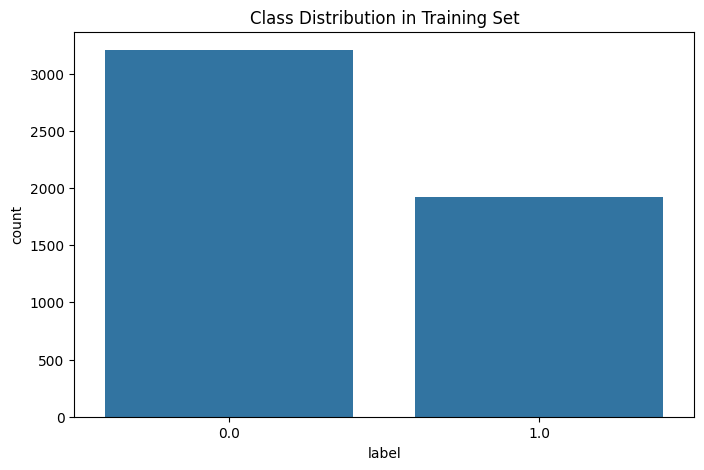

In [28]:
# visualize class distribution
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8,5))
sns.countplot(x=y_train)
plt.title("Class Distribution in Training Set")
plt.show()


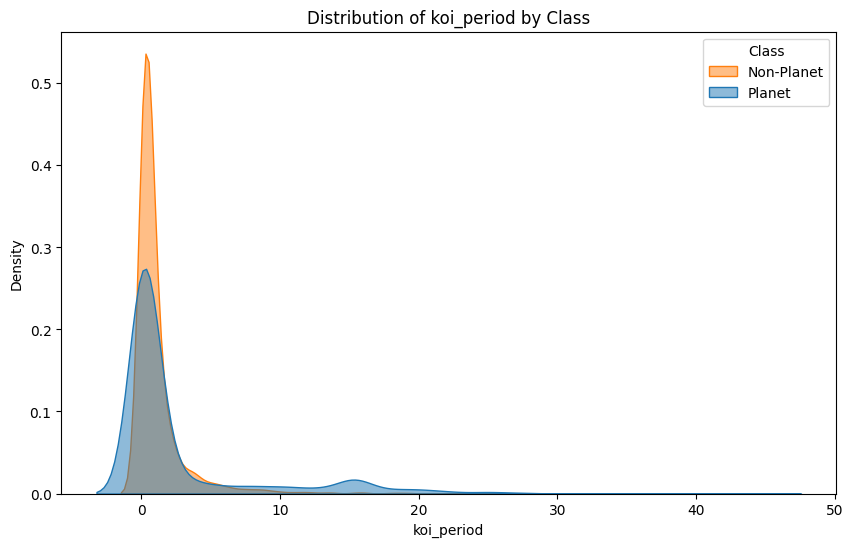

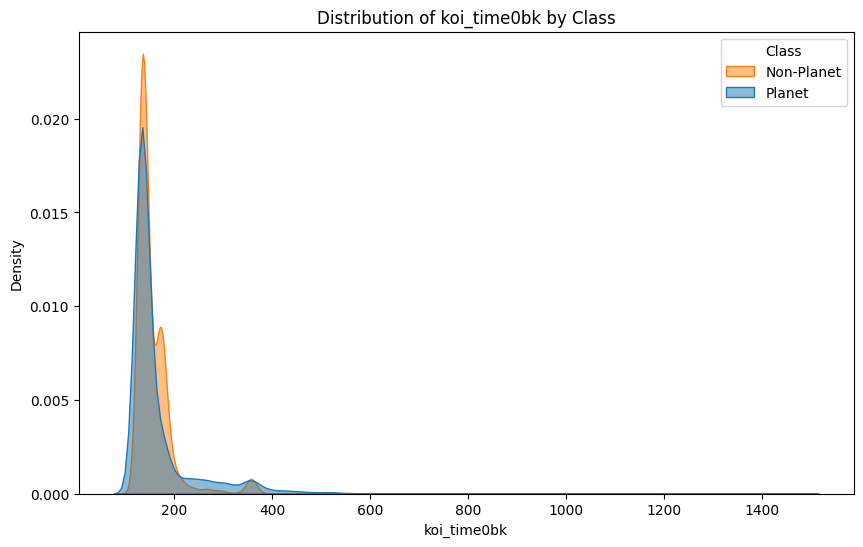

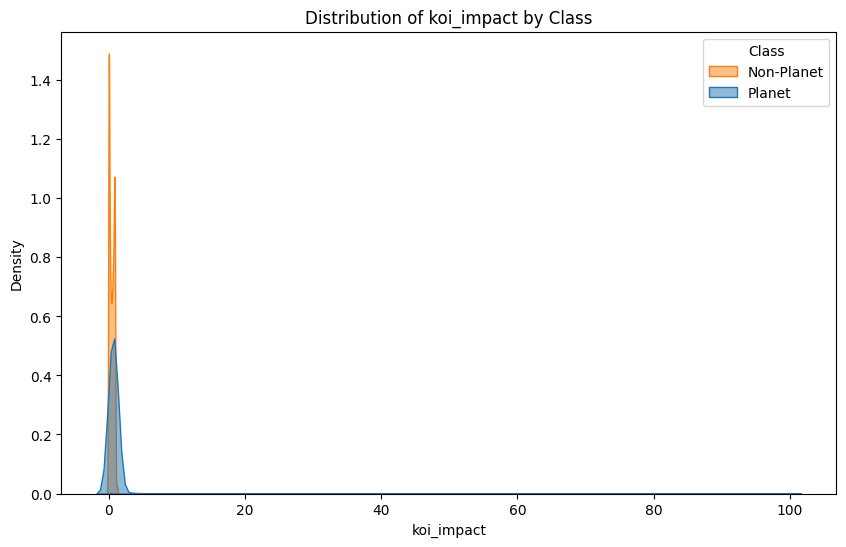

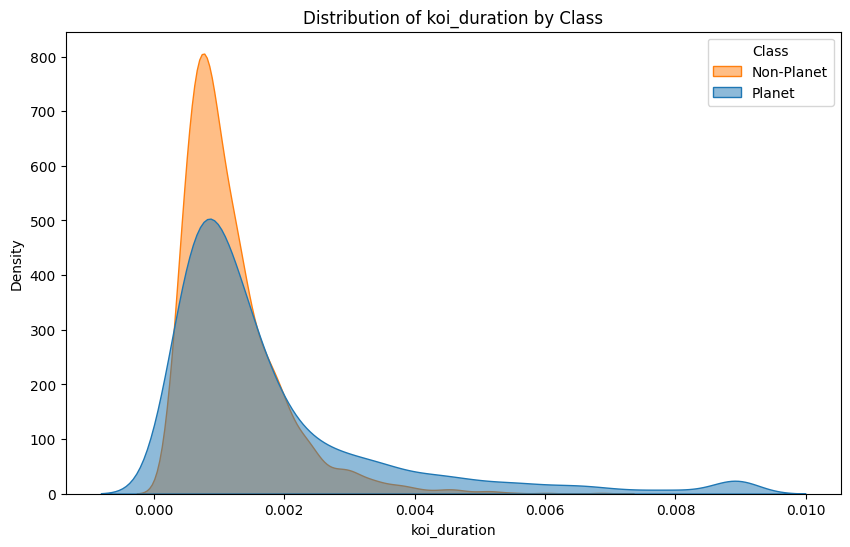

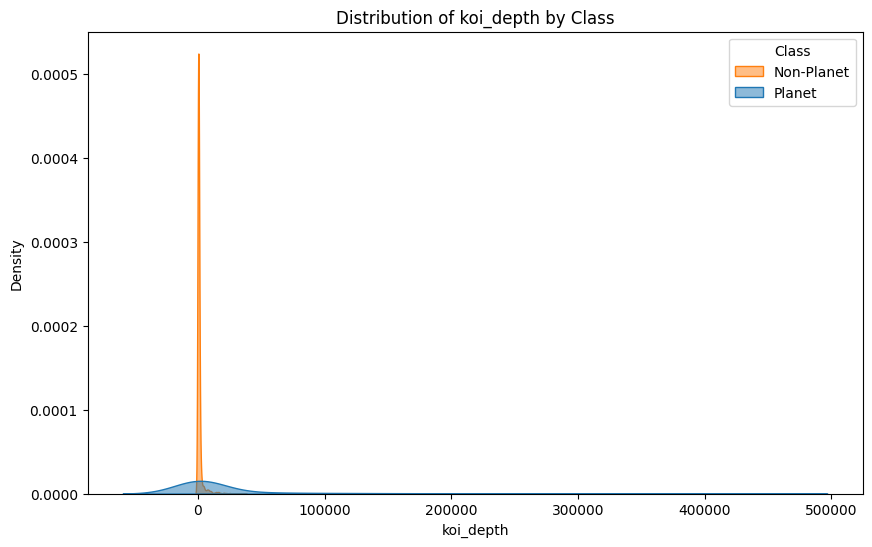

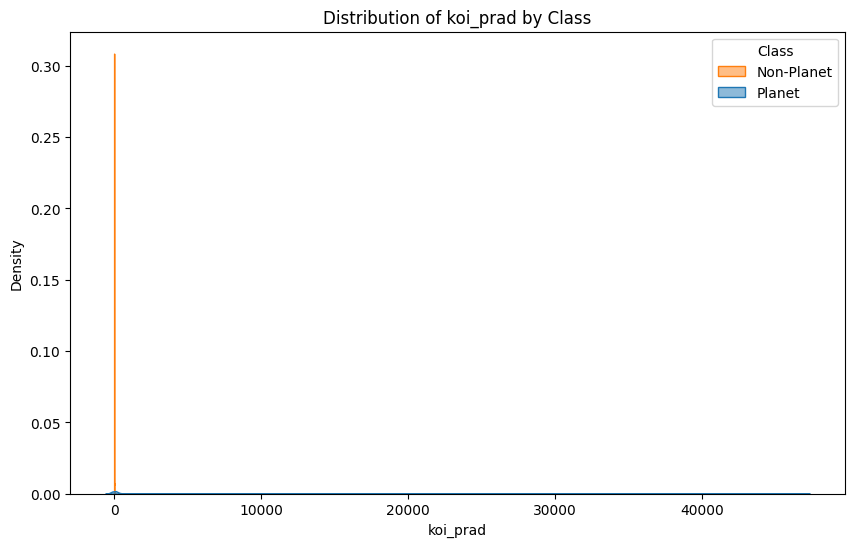

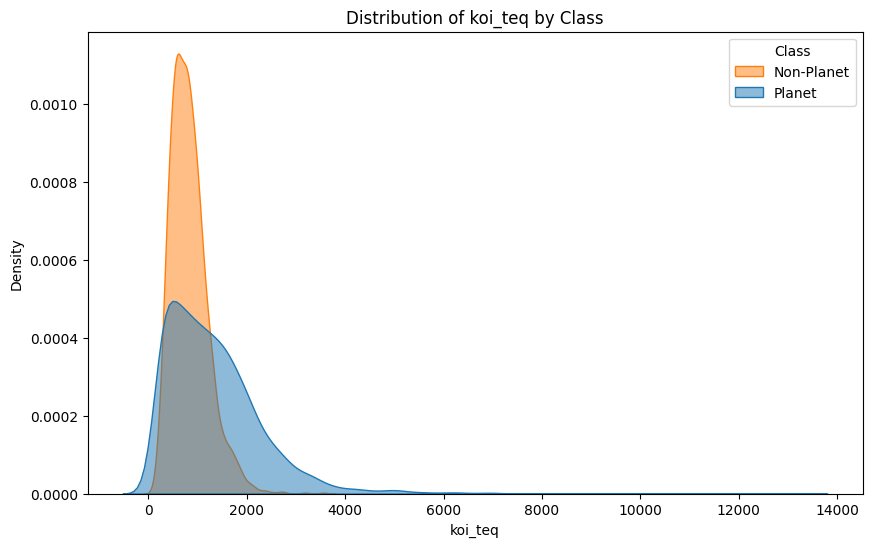

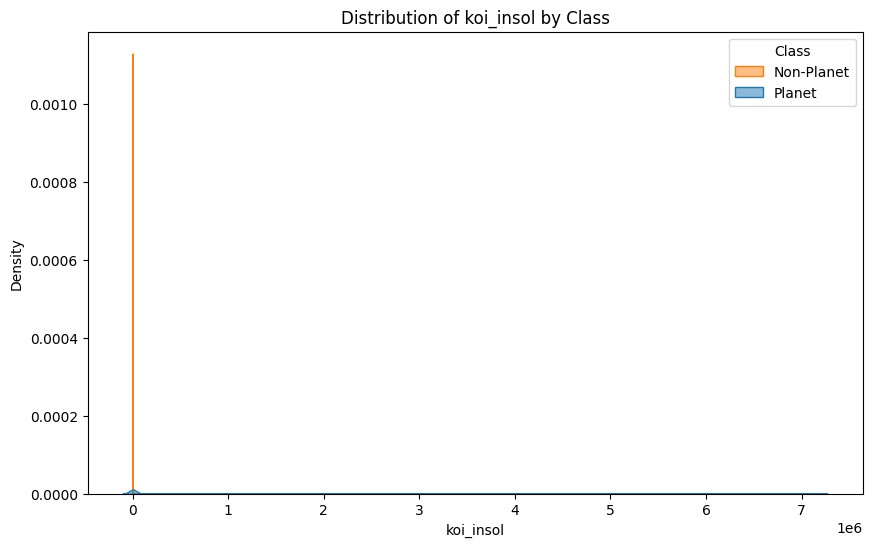

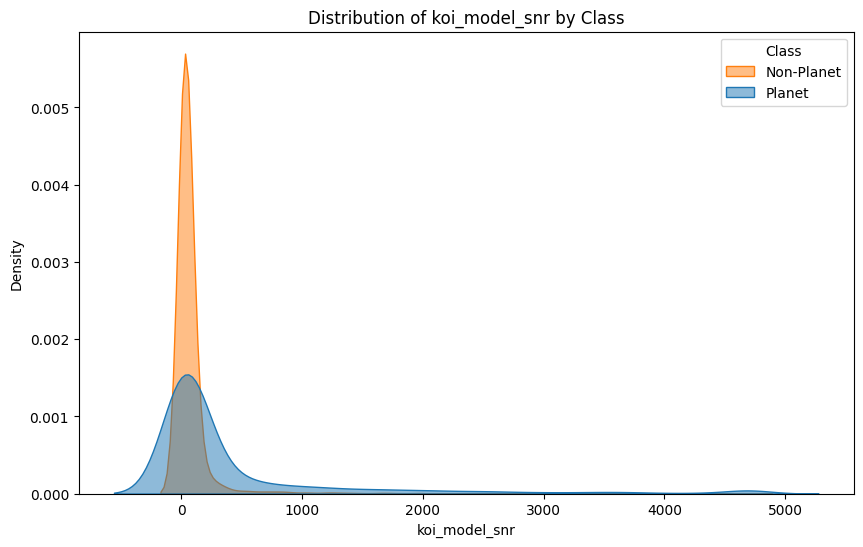

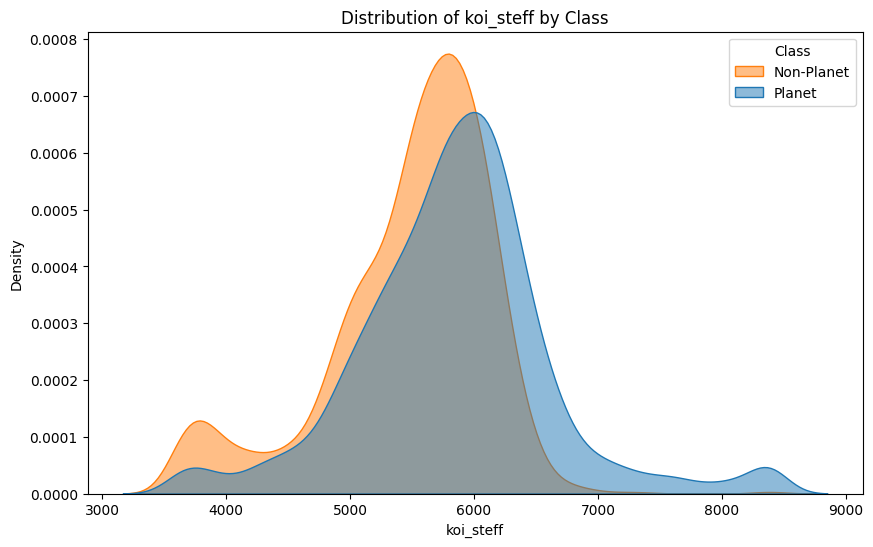

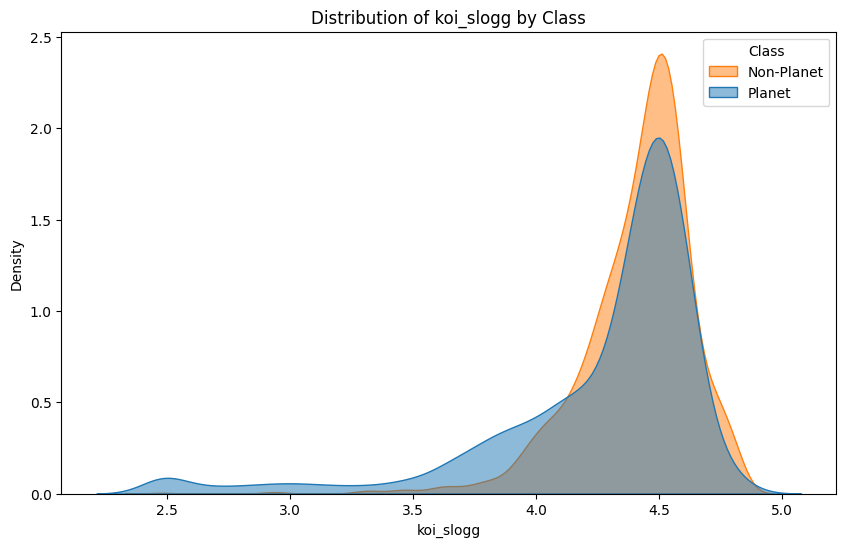

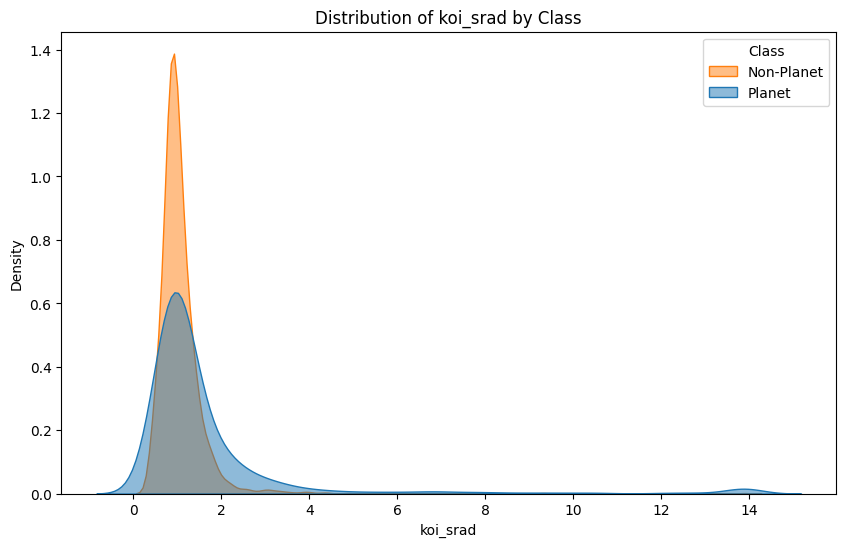

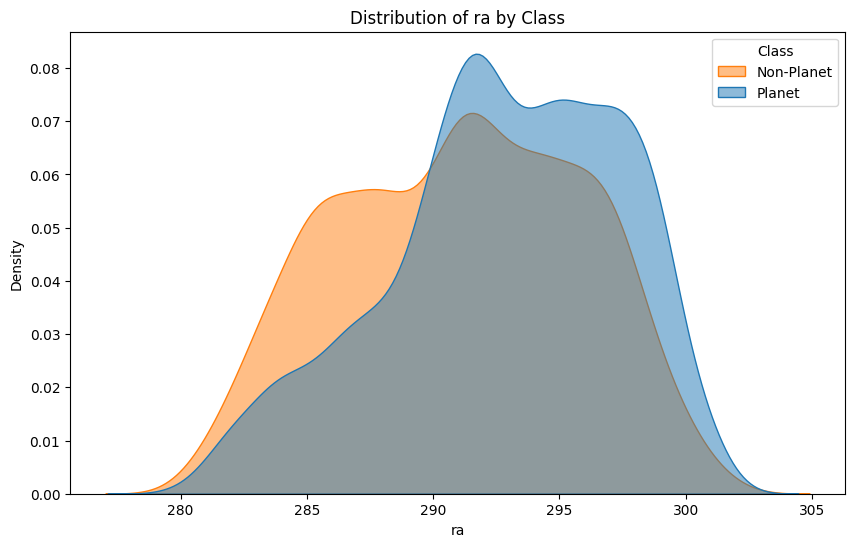

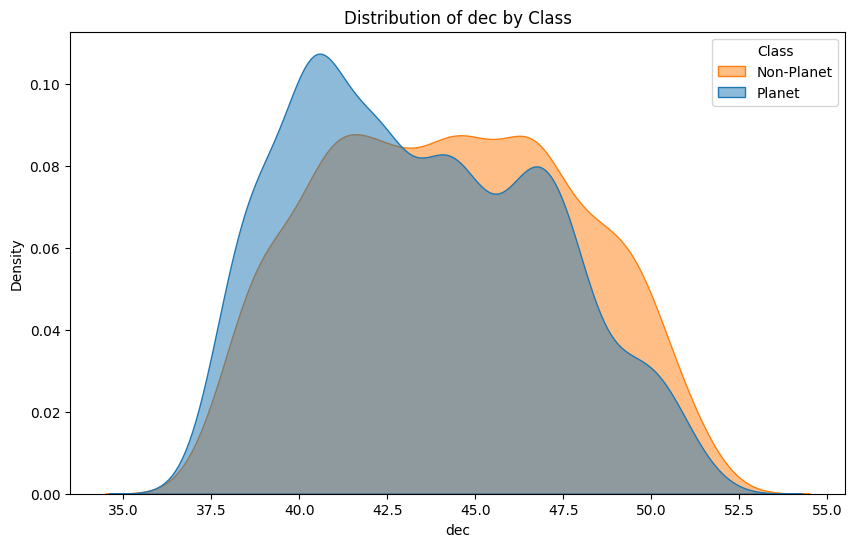

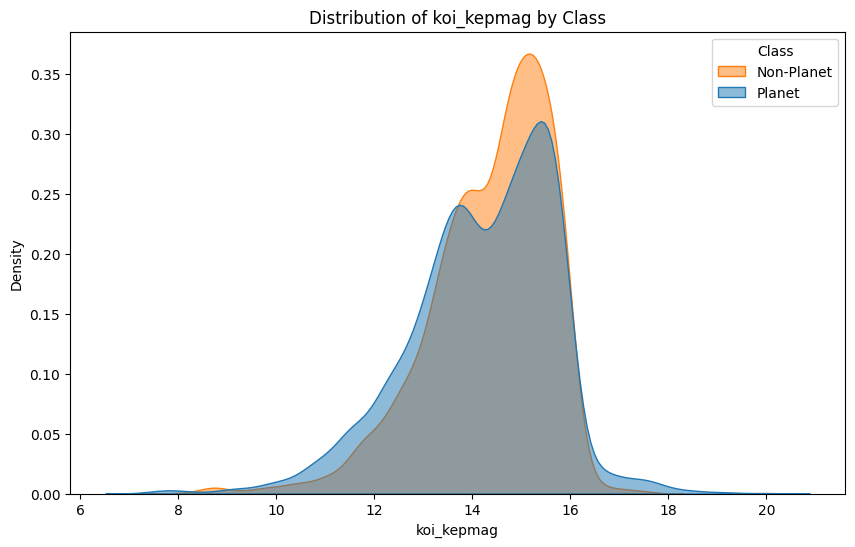

In [32]:
# visualize feature distributions
def plot_feature_distributions(X, y, features):
    for feature in features:
        plt.figure(figsize=(10, 6))
        sns.kdeplot(data=X, x=feature, hue=y, common_norm=False, fill=True, alpha=0.5)
        plt.title(f'Distribution of {feature} by Class')
        plt.xlabel(feature)
        plt.ylabel('Density')
        plt.legend(title='Class', labels=['Non-Planet', 'Planet'])
        plt.show()

plot_feature_distributions(X_train, y_train, FEATURES)

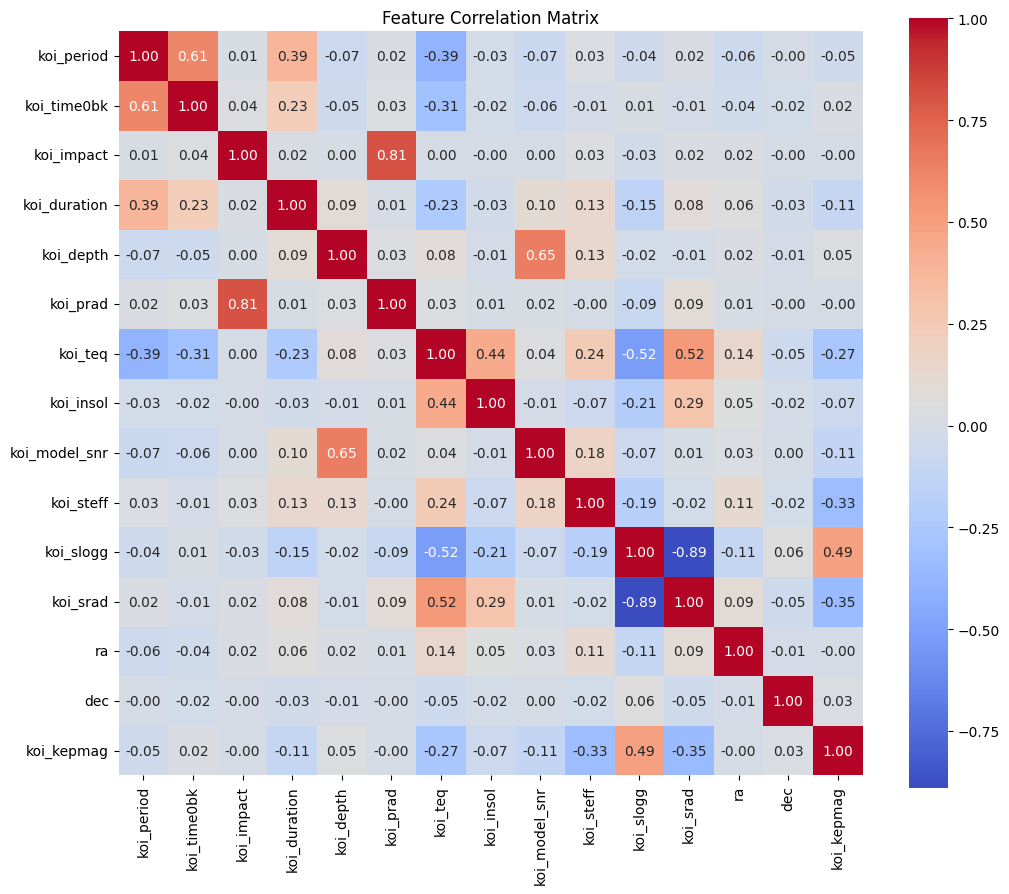

In [33]:
# visualize correlation matrix
plt.figure(figsize=(12,10))
corr = X_train.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Feature Correlation Matrix")
plt.show()

# Training

In [61]:
# start MLP model training pipeline
# Training
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_validate, RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, roc_auc_score,
    average_precision_score, confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay
)
from sklearn.calibration import CalibratedClassifierCV
from sklearn.utils.class_weight import compute_class_weight
from joblib import dump

# create a pipeline with scaling and MLP
# 2-hidden layers with 128 and 64 neurons, relu activation, adam optimizer, early stopping
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features by removing the mean and scaling to unit variance
    ("mlp", MLPClassifier(
        hidden_layer_sizes=(128, 64),  # Two hidden layers with 128 and 64 neurons for sufficient model capacity
        activation="relu",  # ReLU activation function to introduce non-linearity and avoid vanishing gradient
        solver="adam",  # Adam optimizer for efficient and adaptive learning
        learning_rate_init=1e-3,  # Initial learning rate set to 0.001 for balanced convergence speed
        alpha=1e-4,  # L2 regularization term to prevent overfitting
        batch_size=128,  # Mini-batch size for faster training and better generalization
        max_iter=200,  # Maximum number of iterations for training
        early_stopping=True,  # Enable early stopping to prevent overfitting using a validation set
        n_iter_no_change=10,  # Stop training if no improvement in validation score for 10 iterations
        random_state=SEED,  # Set random state for reproducibility
        verbose=True  # Enable verbose output for cleaner logs
    ))
])


In [62]:
# add class weights to handle imbalance
from sklearn.utils.class_weight import compute_class_weight

# Calculate the number of positive and negative samples in the training set
pos = (y_train == 1).sum()  # Count of positive samples
neg = (y_train == 0).sum()  # Count of negative samples

# Compute weights for positive and negative classes to handle class imbalance
w_pos = len(y_train) / (2.0 * max(pos, 1))  # Weight for positive class
w_neg = len(y_train) / (2.0 * max(neg, 1))  # Weight for negative class

# Assign sample weights based on the class of each sample
sample_weight = np.where(y_train == 1, w_pos, w_neg)  # Positive samples get w_pos, negative samples get w_neg

# fit the model
pipeline.fit(X_train, y_train, mlp__sample_weight=sample_weight)

Iteration 1, loss = 0.55813486
Validation score: 0.788396
Iteration 2, loss = 0.44148646
Validation score: 0.819071
Iteration 3, loss = 0.38411342
Validation score: 0.835177
Iteration 4, loss = 0.35442682
Validation score: 0.858572
Iteration 5, loss = 0.33357879
Validation score: 0.860142
Iteration 6, loss = 0.32084489
Validation score: 0.867927
Iteration 7, loss = 0.31252199
Validation score: 0.876248
Iteration 8, loss = 0.30457803
Validation score: 0.876259
Iteration 9, loss = 0.29917708
Validation score: 0.867905
Iteration 10, loss = 0.30027103
Validation score: 0.886129
Iteration 11, loss = 0.28747251
Validation score: 0.887161
Iteration 12, loss = 0.28280370
Validation score: 0.877786
Iteration 13, loss = 0.28436695
Validation score: 0.877281
Iteration 14, loss = 0.27556374
Validation score: 0.884054
Iteration 15, loss = 0.27375582
Validation score: 0.883527
Iteration 16, loss = 0.27132804
Validation score: 0.885076
Iteration 17, loss = 0.26902052
Validation score: 0.883011
Iterat

,steps,"[('scaler', ...), ('mlp', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,hidden_layer_sizes,"(128, ...)"
,activation,'relu'
,solver,'adam'
,alpha,0.0001


In [59]:

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=np.random.seed(42))
scoring = {
    "roc_auc": "roc_auc",
    "ap": "average_precision",
    "f1": "f1",
    "acc": "accuracy"
}

cv_res = cross_validate(
    pipeline,
    X_train, y_train,
    scoring=scoring,
    cv=cv,
    n_jobs=-1,
    return_estimator=False
)

# The following metrics are used to evaluate the model's performance:
# - ROC AUC (Area Under the Receiver Operating Characteristic Curve): Measures the model's ability to distinguish between classes. 
#   A higher value indicates better discrimination between positive and negative classes.
# - PR AUC (Average Precision or AP): Focuses on the precision-recall tradeoff, particularly useful for imbalanced datasets.
#   It evaluates the model's ability to identify positive samples.
# - F1 Score: The harmonic mean of precision and recall, balancing the tradeoff between false positives and false negatives.
#   It is useful when both precision and recall are important.
# - Accuracy: The proportion of correctly classified samples out of the total samples. 
#   It is a general metric but can be misleading for imbalanced datasets.

pd.DataFrame(cv_res).agg(["mean", "std"]).T


,mean,std
fit_time,2.468080,0.621798
score_time,0.073129,0.035972
test_roc_auc,0.945453,0.005426
test_ap,0.897910,0.006734
test_f1,0.850535,0.011900
test_acc,0.884532,0.008708


Test ROC AUC: 0.946
Test PR AUC : 0.899
Test Acc    : 0.873
Test P/R/F1 : 0.794 / 0.892 / 0.840


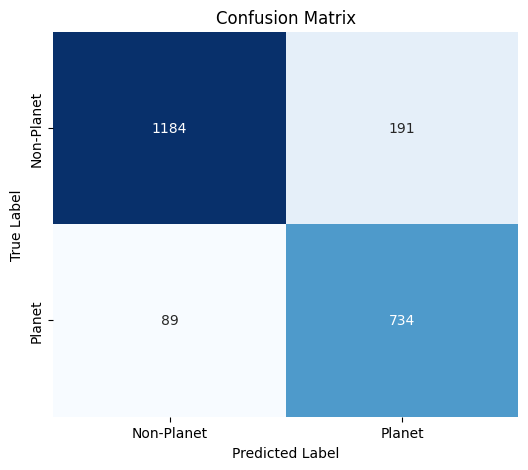

In [60]:
# fit the model on the entire training set
pipeline.fit(X_train, y_train, mlp__sample_weight=sample_weight)

# probability for metrics/plots
x_test_proba = pipeline.predict_proba(X_test)[:, 1]
pred_test_default = (x_test_proba >= 0.5).astype(int)

roc = roc_auc_score(y_test, x_test_proba)
ap  = average_precision_score(y_test, x_test_proba)
acc = accuracy_score(y_test, pred_test_default)
p, r, f1, _ = precision_recall_fscore_support(y_test, pred_test_default, average="binary", zero_division=0)

print(f"Test ROC AUC: {roc:.3f}")
print(f"Test PR AUC : {ap:.3f}")
print(f"Test Acc    : {acc:.3f}")
print(f"Test P/R/F1 : {p:.3f} / {r:.3f} / {f1:.3f}")

# confusion matrix
cm = confusion_matrix(y_test, pred_test_default)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.xticks(ticks=[0.5, 1.5], labels=['Non-Planet', 'Planet'])
plt.yticks(ticks=[0.5, 1.5], labels=['Non-Planet', 'Planet'])
plt.show()



In [48]:
# Evaluation Function
# Imports
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix
)
import matplotlib.pyplot as plt

def evaluate_binary_classification(model, X_test, y_test, plot_roc=True):
    """
    Evaluate a binary classification model with the following metrics:
        - accuracy
        - precision
        - recall
        - f1
        - roc_auc
        - confusion matrix
    """

    y_pred = model.predict(X_test)

    # Probabiliites for ROC AUC
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]  # probability of positive class
    elif hasattr(model, "decision_function"):
        y_prob = model.decision_function(X_test)
    else:
        y_prob = None

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None
    cm = confusion_matrix(y_test, y_pred)

    # Print Metrics
    print("Confusion Matrix:")
    print(cm)
    print("\nAccuracy: {:.4f}".format(acc))
    print("Precision: {:.4f}".format(prec))
    print("Recall: {:.4f}".format(rec))
    print("F1 Score: {:.4f}".format(f1))
    if roc_auc is not None:
        print("ROC AUC: {:.4f}".format(roc_auc))

    # Plot ROC Curve
    if plot_roc and y_prob is not None:
        fpr, tpr, thresholds = roc_curve(y_test, y_prob)
        plt.figure(figsize=(6,6))
        plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
        plt.plot([0,1], [0,1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend()
        plt.show()

    # Return metrics as dict
    metrics_dict = {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1_score": f1,
        "roc_auc": roc_auc,
        "confusion_matrix": cm
    }

    return metrics_dict

Confusion Matrix:
[[1184  191]
 [  89  734]]

Accuracy: 0.8726
Precision: 0.7935
Recall: 0.8919
F1 Score: 0.8398
ROC AUC: 0.9465


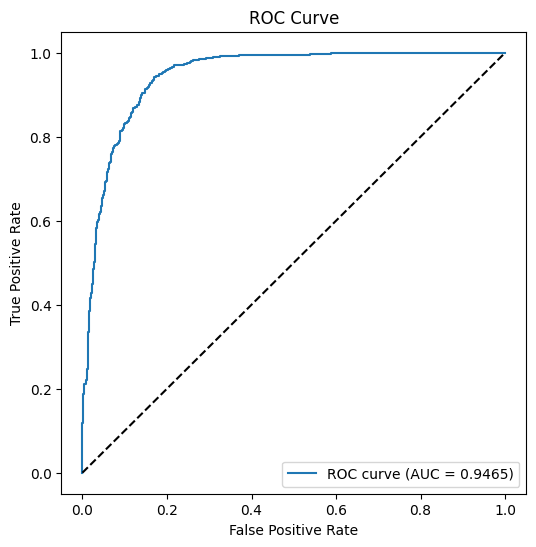

In [49]:
# use evaluation function
metrics = evaluate_binary_classification(pipeline, X_test, y_test)